In [1]:
from Bio.SeqIO.FastaIO import SimpleFastaParser
from Bio.Seq import reverse_complement, Seq
from Bio.SeqUtils import gc_fraction
import config_readwrite as crw

import glob
import gzip
import numpy as np
import os, sys
import pandas as pd
from random import shuffle
import subprocess as sp
import time

# find coordinates of kmers

In [2]:
CL, MER, NMUTS, BUILD, FO_ONLY = "common", "15", "2", "hg38", True
config, cfn = crw.read(os.path.join(os.path.dirname(os.getcwd()), "config.ini"))

In [28]:
# read

# concatenated nullomers
CONCAT= config[f"{CL}.{MER}mer.{NMUTS}mut"]["concat-13"]

# randomly sampled nullomers for single inserts
NULLS = config[f"seed"]['pruned_tsv']

# bed file of common MPRA coordinates
BED = config[CL][f"bed_{BUILD}"]

# extended 4096bp fasta file for common MPRA coordinates
FA_EXT_BED = config[CL][f"fa_extended_{BUILD}"]

# extended 4096 bed file for common MPRA coordinates
EXTENDED = config[CL][f"bed_extended_{BUILD}"]

# fast file for common MPRA coordinates
FA = config[CL][f"fasta_{BUILD}"]

# scaffolds for inserting single nullomers. 
# Chosen because active (top 97.5% Agarwal) | inactive (IQR Agarwal) across 3 cell lines.
# Randomly sample 150 elements from these two categories. 
# Predict scaffold activity with Sei
# Pick scaffolds w/ predicted activity in Sei. (Are these sequences more active than not predicted?)
JOINT_LIBRARY=config["MPRA_AGARWAL"]["joint_library"]
SCAFFOLDS = config["scaffold"]["sampled"]

ROOT = "/wynton/home/ahituv/fongsl/nullomers/results/lock/library_design"

#write

LIBRARY_FILE = os.path.join(ROOT, f'{MER}mer.fo.pam.scaffold'+
              f".ext200.library.tsv")

LIBRARY_CTRL = os.path.splitext(LIBRARY_FILE)[0] + ".ctrl.tsv"

LIBRARY_TWIST = os.path.splitext(LIBRARY_FILE)[0] + ".TWIST.tsv"

out200 = os.path.join(ROOT, f'{MER}mer.fo.pam.scaffold'+
              f".ext200.fa")
out4096 = os.path.join(ROOT, f'{MER}mer.fo.pam.scaffold'+
              f".ext4096.fa")

# write library file to config
config[f"{CL}.{MER}mer.{NMUTS}mut"]["200mers"] = out200
config[f"{CL}.{MER}mer.{NMUTS}mut"]["4096mers"] = out4096
config[f"{CL}.{MER}mer.{NMUTS}mut"]["library"] = LIBRARY_FILE
config[f"{CL}.{MER}mer.{NMUTS}mut"]["library_ctrl"] = LIBRARY_CTRL
config[f"{CL}.{MER}mer.{NMUTS}mut"]["library_twist"] = LIBRARY_TWIST
crw.write(config, cfn)

# functions

In [4]:
def getNullSeqs(file):
    """
    read nullomer/concat sequence .tsv

    input
        file(str) - .txt or .tsv file to nullomer sequences

    method
        1. make empty nulls, kmers list to collect data
        2. iterate through file lines
        3. concatmer - append null, kmer sequences
        4. single nullomers - append just null sequences. 
    return list of nullomers, matching kmers (for concatemers only)
    """

    # read file
    df = pd.read_csv(file, sep='\t')

    # reformat the concat library
    if "nullConcat" in list(df):
        if "id" not in list(df):
            # add id number to concats
            df['id'] = "concat-" + df.index.map(str)

            # save the id in the file
            df.to_csv(file, sep='\t', index=False)

        df = df.rename(columns={"nullConcat": "seq"})

    return df[["id", "seq"]]


def getScaffolds(scaffold_file):

    df = pd.read_csv(scaffold_file, sep='\t')

    return df


def getStrand(scaffold_df):
    """
    return strand of the scaffold sequences

    input
        scaffold_seq_list (list)- list of scaffold coordinates
        lib (pd dataframe) - vikram's 60k common library as pandas dataframe

    method
        1. iterate through seq coordinate list
        1.1 get sequence from coordinate. 
            Because library was in hg38, but scaffolds are in hs1 (i lifted), need to harmonize on sequence using 150 bases

        2. get strand for sequence
            2.1 check for strand conflicts (where sequence matches both to a + and - strand)
        3. if strand is negative, get reverse complement (fwd), else return coor and fwd seq

    return
        scaffold_coor_fa (list) - tuple of coordinates and forward strand sequences

    """
    plus = scaffold_df.loc[scaffold_df.strand == "+"].copy()
    minus = scaffold_df.loc[scaffold_df.strand == "-"].copy()

    plus["fwd.nt"] = plus["200nt"]
    plus["rev.nt"] = plus["200nt"].apply(
        lambda x: "".join(reverse_complement(Seq(x))))

    minus["rev.nt"] = minus["200nt"]
    minus["fwd.nt"] = minus["200nt"].apply(
        lambda x: "".join(reverse_complement(Seq(x))))

    return pd.concat([plus, minus])


def faToDict(fa_file):
    """
    turn all the fa coordinates into a dictionary. 
    """

    fa_dict = {}
    with open(fa_file, "r") as fasta_reader:
        for values in SimpleFastaParser(fasta_reader):

            name, seq = values
            fa_dict[name] = seq

    return fa_dict


def dissectFaId(line):
    """
    dissect mutated fa id line for kmer, nullomer information, and get the coordinate file
    """
    # process the line
    kmer, chr_, coor, strand, id_ = line.strip('\n').strip(">").split(".")

    # get key and value sequence to look up
    key, value_seq = kmer[:5], kmer[5:]

    bed_coor = chr_ + ":" + coor

    # TACCCATTCGAGTC.chr1.100333924-100334124.fwd
    region_str = ".".join([kmer, bed_coor, strand, id_])

    return kmer, key, value_seq, bed_coor, region_str


def seqInsert(seq, insert_start, insert_seq):
    """
    insert sequence fragment (insert_seq) at position (insert_start) within full sequence (seq)

    return inserted sequence. 
    """

    insert_size = len(insert_seq)

    insert_end = insert_start + insert_size  # find center end

    return seq[:int(insert_start)] + insert_seq + seq[int(insert_end):]


def MPRAInsertNull(null_sequence, scaffold_sequence, scaffold_activity):
    """
    return positions where the nullomer is in fa sequence
    """
    if scaffold_activity == "active":
        insert_start = 200 - len(null_sequence)  # place nullomer at the 3' end
    else:
        insert_start = (len(scaffold_sequence) - len(null_sequence))/2

    # insert the nullomer sequence into the sequence
    null_insert = seqInsert(scaffold_sequence.lower(),
                            insert_start, null_sequence.upper())

    return null_insert


def mapBed(bedfile, expandedfile):

    bed = pd.read_csv(bedfile, sep='\t')
    bed.columns = names = ["#chr", "start", "end", "id",  "strand"]
    bed["coor"] = bed["#chr"] + ":" + \
        bed["start"].map(str) + "-" + bed["end"].map(str)

    ext = pd.read_csv(expandedfile, sep='\t', header=None,
                      names=["#chr_e", "start_e", "end_e", "id"])
    ext["coor_e"] = ext["#chr_e"] + ":" + \
        ext["start_e"].map(str) + "-" + ext["end_e"].map(str)

    joint = pd.merge(ext[["id", "coor_e"]], bed[["id", "coor"]])

    return joint


def insert4096(null_seq, joint_bedex, fa_ex_dict, coor):

    # extend the coordinates to 4096
    extended_coor = joint_bedex.loc[joint_bedex["coor"]
                                    == coor, "coor_e"].iloc[0]

    # get the fasta file linked to the extended coordinates
    extended_seq = fa_ex_dict[extended_coor]

    # get the start to insert  # figure out where to insert the sequence
    insert_start = len(extended_seq)/2 - 100

    # insert the 200bp MPRA tile w/ nullomer variants into sequence
    null4096 = seqInsert(extended_seq.lower(), insert_start, null_seq.upper())

    return null4096, extended_seq


def prettifySeq(original, mut):
    """
    prettify sequence. 
        All matching bases will be written as "."
        All non matching bases will be written w mutated base identity. 
    """
    prettyseq = ""
    for o, m in zip(original, mut):
        if o != m:
            prettyseq += m
        else:
            prettyseq += "."

    return prettyseq


def visualInspection(kmer, null, null_ins200, inserts4096, original_seq):
    """
    print a bunch of information related to how this script is 
    inserting kmers into 200bp regions, 
    inserting those 200bp regions into 4096mers
    """

    print("\nkmer\n", kmer)

    print("\nthe nullomer sequence\n",
          null, "\n\ninserted\n", null_ins200)

    print("\n4096 w/ null sequence\n", inserts4096)

    print("\n pretty 4096", prettifySeq(
        original_seq.upper(), list(inserts4096.values())[0].upper()))


def addAdaptor(seq):
    adaptor5, adaptor3 = "AGGACCGGATCAACT", "CATTGCGTGAACCGA"
    adapted = adaptor5 + seq + adaptor3
    return adapted.upper()


def writeRow(file, row):
    """
    append line to file

    input
        file (str) - file to write to
        row (str) - row to write
    method
        1. open file
        2. write
        3. close
    """
    # 1
    with open(file, "a") as writer:
        # 2
        writer.write(row)
    # 3
    writer.close()

# scaffold selection

Scaffold selection? 

See: ./nullomers/bin-lock/Analysis/mpra_corr_scaffold.ipynb
    ./nullomers/bin-lock/Sei_seqeunce_class-scaffold-minmax-selection.ipynb

    Basically, 60K sequences commonly active|inactive 
    across 3 cell lines from Agarwal 2023 were evaluated 
    for MPRA activity (log(rna/dna)). I quantified the mean 
    activity across these three cell lines, then randomly sampled from  
    the top 97.5%, IQR, and bottom 2.5% active sequences 
    
    Then, I predicted the sequence class from each of those 
    common sequences. Of the sequences with interpretable predictions in Sei
    (i.e. sei predicted active sequences as promoter/ enhancer)
    I sampled 50 of the active and 50 of the IQR (marginal activity)
    to use as scaffolds

# Main

In [5]:
def mapBedGenomeBuild(from_, to_, config, cl):
    
    
    for i, build in enumerate([from_, to_]):
        BED = config[cl][f"bed_{build}"]
        cols =[f"chr.{build}", f"start.{build}", f"end.{build}", "id", f"str.{build}"]
    
        bed = pd.read_csv(BED, sep='\t', header=None)
        bed.columns = cols
        bed[f"{build}.coor"] = bed[f"chr.{build}"]+":"+ bed[f"start.{build}"].map(str) +"-"+ bed[f"end.{build}"].map(str)
        
        if i ==0:
            df = bed.copy()
        else:
            merged = pd.merge(df, bed, how='left')
            
    return merged.iloc[1:]
    

build_map = mapBedGenomeBuild("hg38", 'hs1', config, CL)

## set up scaffold FA resources

In [6]:
fa_dict = faToDict(FA) # in hs1
fa_ex_dict = faToDict(FA_EXT_BED) # in hs1

joint_bedex = mapBed(BED, EXTENDED) # in hg38

lib = pd.read_csv(JOINT_LIBRARY, header=1) # in hg38

## get scaffolds

In [7]:
scaffolds_ = getScaffolds(SCAFFOLDS)

print(scaffolds_.groupby("strand")["name"].count())

strand
+    399
-      1
Name: name, dtype: int64


In [8]:
# make sure all the scaffold sequences are in the forward direction
scaffolds = getStrand(scaffolds_)

## insert nulls into scaffold and write
    - takes 12 minutes


In [9]:
if os.path.exists(LIBRARY_FILE) is False:

    out_tsv_dict = {}  # collect data for tsv

    # do single nullomers first
    nulls = getNullSeqs(NULLS)
    concatnulls = getNullSeqs(CONCAT)
    i = 0

    datas = [
             ("single-null", nulls, scaffolds),
             ("concat-null", concatnulls, 
              scaffolds.loc[scaffolds["name"] =="WTC11_seq8625_F"].copy()),
             ]

    # per dataset
    for datatype, seq_list, scaffold_list in datas:
        print(datatype, len(seq_list), len(scaffold_list))

        # per nullomer
        for null_row in seq_list.iterrows():
            null_id, null_seq = null_row[1]
            print(i)
            # per scaffold
            for scaf_row in scaffold_list[["name", "fwd.nt", "scaffold_activity", "hg38.coor"]].iterrows():
                scaf_id, scaf_seq, scaf_act, scaf_coor = scaf_row[1]

                # get hg38, hs1 coordinates (in case)
                coor_hg38, coor_hs1 = list(build_map.loc[build_map["id"] == scaf_id, 
                                                         ["hg38.coor", "hs1.coor"]].iloc[0])


                # get fa sequence for the coordinate, make id from coordinate and the sequence index
                region_id  = null_id + "|" + scaf_id + "|" + scaf_act
                region_fa_id = scaf_coor + "|" + region_id
                #print(region_fa_id)

                # insert nulls, kmers into center of 200bp MPRA sequences.
                seq_ins200 = MPRAInsertNull(
                    null_seq, scaf_seq, scaf_act)  # insert null into scaffold seq

                # insert 200bp null sequence into the 4096 sequence
                seq_ins4096, scaf_seq_ext = insert4096(seq_ins200, joint_bedex, fa_ex_dict, scaf_coor)

                if i == 0:  # if this is the first sequence

                    # write the original sequences
                    writeRow(out200, f">{scaf_coor}_endog_\n{scaf_seq}\n")
                    writeRow(out4096, f">{scaf_coor}_endog_\n{scaf_seq_ext}\n")

                    out_tsv_dict[f"endog-{scaf_id}"] = [f"endog|{scaf_id}|{scaf_act}", "endog", 
                                                  None, scaf_id, scaf_coor, "+", scaf_act,
                                                  None, scaf_seq, 
                                                  addAdaptor(scaf_seq)
                                                 ]

                # write 200mers
                writeRow(out200, f">{region_fa_id}\n{seq_ins200.upper()}\n")

                # write 4096 nullomers
                writeRow(out4096, f">{region_fa_id}\n{seq_ins4096.upper()}\n")

                out_tsv_dict[region_fa_id] = [region_id, f"{datatype}", 
                                              null_id, scaf_id, scaf_coor, "+", scaf_act, 
                                              null_seq.upper(), seq_ins200.upper(), 
                                              addAdaptor(seq_ins200)
                                             ]
            i +=1


    a = [np.array(i) for i in out_tsv_dict.values()]

    df = pd.DataFrame(a)
    before = df.shape[0]
    df= df.drop_duplicates()
    print(before - df.shape[0])

    df.columns=["null_id|scaffold_id|activity","exp.id", "null.id","scaffold.id", "hg38.scaffold.coor", 
                "hg38.str", "scaffold.activity", "seq_frag", "200bp_insert", "200bp_insert+adaptors"]
    df["gc_frac"] = df["200bp_insert"].apply(lambda x:gc_fraction(x))
    df.to_csv(LIBRARY_FILE, sep='\t', index=False)

else:
    df = pd.read_csv(LIBRARY_FILE, sep='\t')

# add control sequences. 

## functions

In [10]:
def dinucScramble(seq, verbose):

    n=2 # pick size 2
    
    splits = [seq[i:i+n] for i in range(0, len(seq), n)]
    shuf_splits = splits[::]
    
    shuffle(shuf_splits)
    
    if verbose is True:
        print(np.unique(splits, return_counts=True))
        print(np.unique(shuf_splits, return_counts=True))
    

    return "".join(shuf_splits)

def checkLength(ctrl):
    ctrl["len"]= ctrl["200bp_insert+adaptors"].apply(lambda x: len(x))

    keep = ctrl.loc[ctrl["len"]==230].copy()
    trim = ctrl.loc[ctrl["len"]==260].copy() # double adaptor!
    
    # trim double adaptor to single adaptor
    trim["200bp_insert+adaptors"] = trim["200bp_insert+adaptors"].apply(lambda x: x[15:-15])
    trim["len"]= trim["200bp_insert+adaptors"].apply(lambda x: len(x))

    ctrl = pd.concat([keep, trim])
 
    return ctrl

def getAgarwalCtrls(lib):

# get control
    ctrl = lib.loc[
                    (lib["category"].str.contains("negative")) |
                    (lib["category"].str.contains("positive"))
                     ].drop_duplicates()

    ctrl = ctrl.loc[ctrl["category"]!="negative, shuffled"]
    ctrl = ctrl[['name',
                 'category',
                 'chr.hg38',
                 'start.hg38',
                 'stop.hg38',
                 'str.hg38',
                 "230nt sequence (15nt 5' adaptor - 200nt element - 15nt 3' adaptor)"]]

    # fillna
    ctrl = ctrl.fillna(-1)

    # build the coordinate field
    ctrl["hg38.scaffold.coor"] = "chr" + ctrl["chr.hg38"].map(str) +\
                                ":" + ctrl["start.hg38"].map(int).map(str) +\
                                "-" + ctrl["stop.hg38"].map(int).map(str)

    # rename columns
    ctrl = ctrl.rename(columns={"name":"scaffold.id", 
                                "category":"exp.id",
                                "str.hg38": "hg38.str", 
                                "230nt sequence (15nt 5' adaptor - 200nt element - 15nt 3' adaptor)":'200bp_insert+adaptors'
                        })

    # trim adaptors
    ctrl["200bp_insert"]  = ctrl["200bp_insert+adaptors"].apply(lambda x: x[15:-15])
    ctrl["gc_frac"]= ctrl["200bp_insert"].apply(lambda x: gc_fraction(x))

    # add in empty fields. 
    ctrl['null.id'] = None
    ctrl["null_id|scaffold_id|activity"] = ctrl['null.id'].map(str) + "|" + ctrl['scaffold.id'] + "|" + ctrl['scaffold.activity']
    ctrl['scaffold.activity'] = ctrl["exp.id"].apply(lambda x: "inactive" if "negative" in x else "active")
    ctrl["seq_frag"]=None

    return ctrl

def getEndogSeqNScramble(df, n_scramble):

    endog_dict = {}

    # per scramble
    for i in np.arange(n_scramble):

        # make copy of endog dataframe rows
        endog_seqs = df.loc[df["exp.id"] == "endog"].copy()

        # change a bunch of vals
        # id - update w/ scramble iter
        endog_seqs['exp.id']="endog-scramble"
        endog_seqs['null.id'] = f"endog-scramble-{i}"
        endog_seqs["null_id|scaffold_id|activity"] = f"endog-scramble-{i}" + \
            "|" + endog_seqs["scaffold.id"]

        # scramble!
        endog_seqs["200bp_insert"] = endog_seqs["200bp_insert"].apply(
            lambda x: dinucScramble(x, False))

        # add adaptors to scramble!
        endog_seqs["200bp_insert+adaptors"] = endog_seqs["200bp_insert"].apply(
            lambda x: addAdaptor(x))

        # quantify GC fraction of scramble! (Should be the same!)
        endog_seqs["gc_frac"] = endog_seqs["200bp_insert"].apply(
            lambda x: gc_fraction(x))

        # add scramble to dictionary
        endog_dict[i] = endog_seqs.copy()

    endog_seqs = pd.concat(endog_dict.values())

    return endog_seqs

## get positive controls from Agarwal MPRA
## scramble scaffold sequences

In [11]:
if os.path.exists(LIBRARY_CTRL) is False:
    # get controls from library
    ctrl = getAgarwalCtrls(lib)
    print(ctrl.shape)

    # rearrange columns to be like df
    ctrl = ctrl[list(df)]

    N_SCRAMBLE = 3
    endog_scram = getEndogSeqNScramble(df, N_SCRAMBLE)

    # add positive controls, scaffold scrambles
    ctrl = pd.concat([ctrl, endog_scram])
    print(ctrl.shape)

    # add the nullomer inserts
    ctrl = pd.concat([ctrl, df])

    # quantify length
    ctrl = checkLength(ctrl)
    print(ctrl.shape)

    ctrl = ctrl.rename(columns={"seg_frag": "seq_insert"})

    # reorganize columns
    ctrl = ctrl[[
        'exp.id', 'null.id', 'scaffold.id',
        'null_id|scaffold_id|activity', 'hg38.scaffold.coor', 'hg38.str',
        'gc_frac', 'len',
        'scaffold.activity', 
         '200bp_insert+adaptors',
        'seq_frag',
        #'200bp_insert',

    ]].sort_values(by=["exp.id", "scaffold.id"])

    # rename column "seq_frag" to "insert_seq" 
    ctrl=ctrl.rename(columns = {"seq_frag":"insert_seq"})

    # SAVE
    ctrl.to_csv(LIBRARY_CTRL, sep='\t', index=False)

else:
    ctrl = pd.read_csv(LIBRARY_CTRL, sep='\t')

ctrl.head()

,exp.id,null.id,scaffold.id,null_id+scaffold_id,hg38.scaffold.coor,hg38.str,gc_frac,len,scaffold.activity,200bp_insert+adaptors,insert_seq
0,concat-null,concat-0,WTC11_seq8625_F,concat-0|WTC11_seq8625_F|inactive,chr10:37754790-37754990,+,0.570,230,inactive,AGGACCGGATCAACTGATATTCGCTCAACCGGAACGAATGTCGACG...,TATTCGCTCAACCGGAACGAATGTCGACGGTAACGTCGAGTGCGGT...
1,concat-null,concat-1,WTC11_seq8625_F,concat-1|WTC11_seq8625_F|inactive,chr10:37754790-37754990,+,0.560,230,inactive,AGGACCGGATCAACTGATTCGAACGCAAGCGGTAATTACGTCGACG...,TTCGAACGCAAGCGGTAATTACGTCGACGGGTTGCGAGTAGTCGGC...
2,concat-null,concat-2,WTC11_seq8625_F,concat-2|WTC11_seq8625_F|inactive,chr10:37754790-37754990,+,0.580,230,inactive,AGGACCGGATCAACTGACCATCGATCGAACGGCCGGTATTGGATCG...,CCATCGATCGAACGGCCGGTATTGGATCGGCTAGATCGACGGAGGC...
3,concat-null,concat-3,WTC11_seq8625_F,concat-3|WTC11_seq8625_F|inactive,chr10:37754790-37754990,+,0.585,230,inactive,AGGACCGGATCAACTGAACCGCTATATTGCGGTTATTGCGCGAGCG...,ACCGCTATATTGCGGTTATTGCGCGAGCGGTATCGACGAAGGCGGG...
4,concat-null,concat-4,WTC11_seq8625_F,concat-4|WTC11_seq8625_F|inactive,chr10:37754790-37754990,+,0.580,230,inactive,AGGACCGGATCAACTGAAAGCGCGTCTATCGGCCTTAGTTCGGACG...,AAGCGCGTCTATCGGCCTTAGTTCGGACGGTTCGATACGGGTCGGC...


## double check 
### adaptors

In [23]:
set(ctrl["200bp_insert+adaptors"].apply(lambda x: x[:15])),set(ctrl["200bp_insert+adaptors"].apply(lambda x: x[-15:]))

({'AGGACCGGATCAACT'}, {'CATTGCGTGAACCGA'})

In [25]:
for_twist = ctrl[['null_id|scaffold_id|activity', '200bp_insert+adaptors']].drop_duplicates().copy()

In [29]:
for_twist.to_csv(LIBRARY_TWIST, sep='\t', index=False)

### check scrambles

In [24]:
ctrl.loc[(ctrl['scaffold.id'] == "HepG2_DNasePeakNoPromoter20370")
         & (ctrl["exp.id"].str.contains("endog")), ['exp.id',
                                                    'null.id',
                                                    'scaffold.id',
                                                    'null_id|scaffold_id|activity',
                                                    'hg38.scaffold.coor',
                                                    'hg38.str',
                                                    'gc_frac',
                                                    'len',
                                                    'scaffold.activity',
                                                    # 'seq_frag',
                                                    # '200bp_insert',
                                                    '200bp_insert+adaptors']]

,exp.id,null.id,scaffold.id,null_id+scaffold_id,hg38.scaffold.coor,hg38.str,gc_frac,len,scaffold.activity,200bp_insert+adaptors
764,endog,NaN,HepG2_DNasePeakNoPromoter20370,endog,chr15:72237529-72237729,+,0.525,230,active,AGGACCGGATCAACTAGCTGGTAAGAAACCCAGTAATGACTCAGCA...
764,endog-scramble,endog-scramble-0,HepG2_DNasePeakNoPromoter20370,endog-scramble-0|HepG2_DNasePeakNoPromoter20370,chr15:72237529-72237729,+,0.525,230,active,AGGACCGGATCAACTGGGGCCTGCCCGGACTAGGGGACCATAAACA...
764,endog-scramble,endog-scramble-1,HepG2_DNasePeakNoPromoter20370,endog-scramble-1|HepG2_DNasePeakNoPromoter20370,chr15:72237529-72237729,+,0.525,230,active,AGGACCGGATCAACTTAAAAACACATCCAGAAAGTACATCACTGGC...
764,endog-scramble,endog-scramble-2,HepG2_DNasePeakNoPromoter20370,endog-scramble-2|HepG2_DNasePeakNoPromoter20370,chr15:72237529-72237729,+,0.525,230,active,AGGACCGGATCAACTGACTCCGGCCTCAGTCCACTGGACTCCAGAG...


### test for k562 alignment

In [54]:
check_cols = ["scaffold.id", "200bp_insert", "hg38.scaffold.coor"]
ctrl.loc[ctrl["scaffold.id"].str.contains("K562"), check_cols].iloc[271]

scaffold.id                                              K562_peak26939
200bp_insert          TCAAAGTCAACCAGGCAGCTGCCTTACTTAAATTCATTTCCCTCAG...
hg38.scaffold.coor                              chr15:40962392-40962592
Name: 480, dtype: object

### check one sequence

### align ucsc v. our seq

In [50]:
# ids we tested

IDS = {
    "K562_peak10458":"CCCAGATCAATAAACTTGCTCATCTGCTCTTATGGCCCCCACCCAGTAACTGACTCAGTGCAAGAAGACAGCTGACTCACGGCCATTTCATCTCTGACCAATCAGCACCCTTGGCTCACTGGCTTACCGATTTCATCTCTGACCAATCAGCACTCCTGGCTCACTGGCTTACCAATTTCATCTCTGACCAATCAGCACTC",
    "K562_peak49867":"GCGGGGGAGGTGAGATTGGAAGGATGCCAGGAATCTTGGGCCCAGCTGCTGCTTTATGACTTAGGGATATAACTGCTTCTGACTCATGCGTGCTTGGCTCTTTGTGATTATGTGCTGAGACACGTCAGCGGGAGGCTGCCCCGGAATGTCTCCCCATGCGAATCGAGGGTGGGGCCTCTGCTGAGTCACCTCTGGCTCCT", 
    "K562_peak26939":"AGCGCCCTGACAAAACAGGCCACTCGGCTCTACCAATCAGCAAGATGTGGGTGGGGCCAGATAAGAGAATAAAAGCAGGCTGCCCGAGCTTGCATTAGTAACTCGCTCGGGTCCCCTTCCGGATTGTGGAAACTTTGTTCTTTCGCTGTATGTAATAACTCTTGCTACTGTAGCTCGCTTTTTGGGTCTACGCTGCTTCT"
}

# align our sequence to UCSC sequence

for name, ucsc_seq in IDS.items():
    

    # check MPRA sequence
    mpra_seq=ctrl.loc[ctrl["scaffold.id"]==name, "200bp_insert"].iloc[0]
    v=0
	for i, j in zip(ucsc_seq, mpra_seq):
	    if i==j:  # if nucleotide aligns
	        continue
	    else:   # if nucleotide does not aligns
	        print(v, i, j)
	    v+=1  # count the index
	
## all results returned were negative


## counts of all the experimental categories

In [54]:
ctrl.groupby("exp.id")["hg38.scaffold.coor"].count(), ctrl.groupby("exp.id")["hg38.scaffold.coor"].count().sum()

(exp.id
 concat-null                 325
 endog                       400
 endog-scramble             1200
 negative HepG2, Smith       169
 positive HepG2, Smith       181
 positive K562, Kellis        50
 single-null              107200
 Name: hg38.scaffold.coor, dtype: int64,
 109525)

In [60]:
frag, insert = ctrl.loc[(ctrl["scaffold.activity"]=="active") 
         & (ctrl["exp.id"]=="single-null"), 
         ["seq_frag", "200bp_insert"]].iloc[0]

# GC content

In [65]:
df["gc_frac"].describe()

count    107925.000000
mean          0.522703
std           0.047965
min           0.395000
25%           0.490000
50%           0.525000
75%           0.565000
max           0.615000
Name: gc_frac, dtype: float64

In [66]:
import seaborn as sns

In [67]:
set(df["exp.id"])

{'concat-null', 'endog', 'single-null'}

<Axes: xlabel='gc_frac', ylabel='Count'>

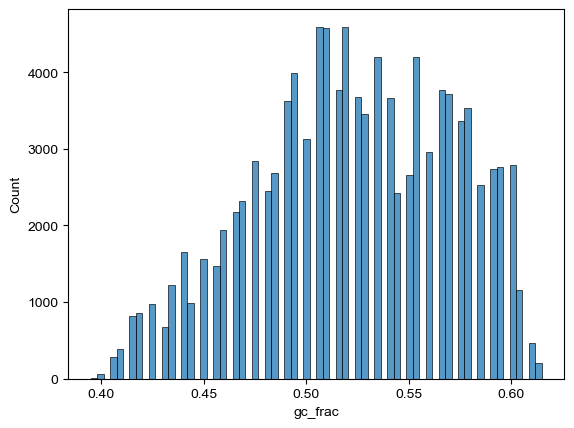

In [68]:
sns.histplot(df["gc_frac"])

In [69]:
hi_gc = df.loc[df["gc_frac"]>0.60]
hi_gc.groupby("exp.id").count()

,null_id+scaffold_id,null.id,scaffold.id,hg38.scaffold.coor,hg38.str,scaffold.activity,seq_frag,200bp_insert,200bp_insert+adaptors,gc_frac
exp.id,,,,,,,,,,
single-null,1830,1830,1830,1830,1830,1830,1830,1830,1830,1830
